# Surface analysis for flow boilling studies

In [1]:
#Imports
import numpy as np
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import ipywidgets as widgets

from numpy import pi
from scipy import integrate

The aim of this document is to provide a parametric study of a given surface's characteristic, in regard of the study of two-phase flows. Hence, several surface characteristic will be studied, including the roughness and the associated electrical filters.

## Data acquisition

In [2]:
#df = pd.read_csv(filedialog.askopenfile(mode='r'),decimal=',',sep=';')

In [3]:
#get data from a csv file

path = "C:/Users/yberton/Documents/Expérimental/Rugosité/Mesures/Tube inox test/23-11-2023.csv"
df = pd.read_csv(path, encoding='unicode_escape',decimal=',',sep=';') # Store data in a DataFrame
df = df[df.iloc[:,1] != 0] #Withdraw 0 value error measured by the microscope
df.set_index(df.iloc[:,0],inplace=True) #Set transerval length as index
df.drop(['Y [mm]'], axis=1,inplace=True) #Drop it afterward
df.rename(columns={'Z [mm]' : 'Zum', 'Y [mm]' : 'Ymm'}, inplace=True) #Quick rename for better display
df_zoom = df[df.index >= 1] #Create a dataframe copy with Y value above 1mm (end of the study length)

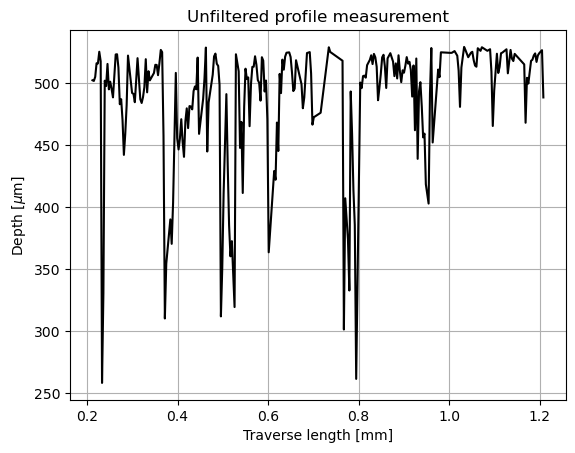

In [4]:
#Unfiltered profile measurement display
fig,ax = plt.subplots(1,1)
ax.set_title("Unfiltered profile measurement")
ax.plot(df.index,df.iloc[:,0], 'k')
ax.set_xlabel('Traverse length [mm]')
ax.set_ylabel(r'Depth [$\mu$m]')
ax.grid()
plt.show()

In [9]:
#band-pass filter

from scipy import signal
%matplotlib qt5

df["Zum"] = df["Zum"] - df["Zum"].mean()

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    try : 
        b, a = butter_highpass(cutoff, fs, order=order)
        y = signal.filtfilt(b, a, data)
    except ValueError :
        print("Erreur de valeur / Combinaison fps-cutoff impossible")
    return y

def update(cutoff = 10, fps = 30):
    try : 
        df["FilteredZum"] = butter_highpass_filter(df.iloc[:,0].values,cutoff,fps)
    except UnboundLocalError : 
        pass
    line2.set_ydata(df["FilteredZum"])
    axs[1] .set_title('Primary Profile with cutoff = %.3f mm' %round(cutoff,2))
    fig.canvas.draw_idle()

        
fps = 30
cutoff  =  2.5
df["FilteredZum"] = butter_highpass_filter(df.iloc[:,0].values,cutoff, fps)

fig, axs = plt.subplots(2,1,figsize=(20,10))

line1, = axs[0].plot(df.index,df.iloc[:,0], 'k')
axs[0].set_title('Unfiltered Surface Profile')
axs[1].set_title('Filtered Surface Profile with cutoff = %f' %round(cutoff,6))
line2, = axs[1].plot(df.index,df["FilteredZum"])
axs[1].set_ylim(-250,65)
for ax in axs : 
    #Axis setter
    ax.spines['left'].set_position((('data', df.index[-1])))
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position((('data', df["Zum"].mean())))
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel('Traverse length [mm]', loc="right")
    ax.set_ylabel(r'Depth [$\mu$m]', loc="top")
    
    
widgets.interact(update,
                 cutoff=widgets.FloatSlider(min=0.001,max=14.5,step=0.001,value=0.5),
                 fps = widgets.FloatSlider(min=0.001,max=100,step=0.001,value=30));


interactive(children=(FloatSlider(value=0.5, description='cutoff', max=14.5, min=0.001, step=0.001), FloatSlid…

In [6]:
#Ra calculus

integre = lambda y,z: integrate.trapz(z, x=y)
roughness = lambda Y,Z,L : integre(Y,Z)/(L)
y = df.index ; z = abs(df['Zum'])
Y = y[::-1].values ; Z = z[::-1].values
Ra = roughness(Y,Z,(df.index[0]-df.index[-1]))
print("Ra = %0.3f um" %Ra)

#Ra_zoom calculus
y = df_zoom.index ; z = abs(df_zoom['Zum'])
Y = y[::-1].values ; Z = z[::-1].values 
Ra_zoom =  roughness(Y,Z,(df_zoom.index[0] - df_zoom.index[-1]))
print("Ra_zoom = %0.3f um" %Ra_zoom)


Ra = 35.506 um
Ra_zoom = 517.851 um


In [ ]:
#Nice plot
fig, ax = plt.subplots(1,1,figsize=(7*(1+5**0.5)/2,2))
#(2,2*(1+5**0.5)/2)
ax.spines['bottom'].set_position((('data', df["Zum"].mean())))
ax.plot(df.index, df['Zum'], 'k', label="Surface's profil")
ax.plot(df.index, [Ra + df["Zum"].mean() for i in range(len(df.index))], '--r')
#ax.plot(df.index, [-Ra + df["Zum"].mean() for i in range(len(df.index))], '--g')
ax.set_xlabel('Traverse length [mm]')
ax.set_ylabel(r'Depth [$\mu$m]')
ax.set_xlim(df.index.min(),df.index[0])
ax.set_ylim(df['Zum'].min(),df['Zum'].max())
ax.legend()
plt.show()

#Rq, Rv
Rp = df_zoom['Zum'].max()
Rv = df_zoom['Zum'].min()


In [ ]:
df_test = df.copy()
df_test["Zum"] = df["Zum"] - df["Zum"].mean()

y = df_test.index ; z = abs(df_test['Zum'])
Y = y[::-1].values ; Z = z[::-1].values
Ra = roughness(Y,Z,(df_test.index[0]-df_test.index[-1]))
print(Ra)

#Nice plot
fig, ax = plt.subplots(1,1,figsize=(7*(1+5**0.5)/2,2))
ax.spines['bottom'].set_position((('data', df_test["Zum"].mean())))
ax.plot(df_test.index, df_test['Zum'], 'k', label="Surface's profil")
ax.plot(df_test.index, [Ra for i in range(len(df_test.index))], '--r')
ax.plot(df_test.index, [-Ra for i in range(len(df_test.index))], '--r')
#ax.plot(df.index, [-Ra + df["Zum"].mean() for i in range(len(df.index))], '--g')
ax.set_xlabel('Traverse length [mm]')
ax.set_ylabel(r'Depth [$\mu$m]')
ax.set_xlim(df_test.index.min(),df_test.index[0])
ax.set_ylim(df_test['Zum'].min(),df_test['Zum'].max())
ax.legend()
plt.show()

print(df_test.index[0]-df_test.index[-1])


In [ ]:
print(Z[0]) 
print(z.iloc[-1])

In [ ]:
#Plot the zoomed part
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(7*(1+5**0.5)/2,2))
#plots
#Profil
ax.plot(df_zoom.index, df_zoom['Zum'],'-k')
#Ra
ax.plot(df_zoom.index, [Ra_zoom +  df_zoom["Zum"].mean() for i in range(len(df_zoom))],'--r')
ax.plot(df_zoom.index, [-Ra_zoom+  df_zoom["Zum"].mean() for i in range(len(df_zoom))],'--r')
#Rp
ax.plot(df_zoom.index, [Rp for i in range(len(df_zoom))],'--k')
#Rv
ax.plot(df_zoom.index, [Rv for i in range(len(df_zoom))],'--k')

#Axis setter
ax.spines['left'].set_position((('data', df_zoom.index[-1])))
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position((('data', df_zoom["Zum"].mean())))
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('Traverse length [mm]', loc="right")
ax.set_ylabel(r'Depth [$\mu$m]', loc="top")
#Put arrow at the edge of the axis
ax.plot((1), (df_zoom["Zum"].mean()), ls="", marker=">", ms=10, color="k",
        transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot((df_zoom.index[-1]), (1), ls="", marker="^", ms=10, color="k",
        transform=ax.get_xaxis_transform(), clip_on=False)

plt.show()